In [65]:
import os
import re
import matplotlib.pyplot as plt

def parse_logs(log_directory):
    log_data = []
    
    for log_file in os.listdir(log_directory):
        if log_file.endswith(".log"):
            with open(os.path.join(log_directory, log_file), "r") as file:
                log_content = file.read()
                
                # Parse hyperparameters
                hyperparameters = {}
                pattern = r'"(.*?)": "?(.*?)"?,\s*\n'
                matches = re.findall(pattern, log_content)
                for match in matches:
                    key, value = match
                    hyperparameters[key] = value
                
                log_data.append({"log_file": log_file, "hyperparameters": hyperparameters})
    
    return log_data

def filter_logs(log_data, hyperparameter_filters):
    filtered_logs = []
    
    for log in log_data:
        if all(log["hyperparameters"].get(param) == value for param, value in hyperparameter_filters.items()):
            filtered_logs.append(log["log_file"])
    
    return filtered_logs

def generate_graph(log_files):
    plt.figure(figsize=(8, 6))
    legends = []

    for log_file in log_files:
        # print(f'reading log {log_file}')
        comm_rounds = []
        test_accuracies = []
        LOG_FILE_PATH = './logs/'

        with open(f"{LOG_FILE_PATH}{log_file}", "r") as file:
            log_content = file.read()

        pattern = r"in comm round:(\d+).*?>> Global Model Test accuracy: (\d+\.\d+)"
        matches = re.findall(pattern, log_content, re.DOTALL)

        for match in matches:
            comm_round = int(match[0])
            test_accuracy = float(match[1])
            comm_rounds.append(comm_round)
            test_accuracies.append(test_accuracy)

        def extract_hyperparameter(log_content, parameter):
            pattern = rf'"{parameter}": "?([\w-]+)"?,'
            match = re.search(pattern, log_content)
            if match:
                return match.group(1)
            return None

        split_layer = extract_hyperparameter(log_content, "split_layer")
        partition = extract_hyperparameter(log_content, "partition")
        model = extract_hyperparameter(log_content, "model")
        dataset = extract_hyperparameter(log_content, "dataset")

        plt.plot(comm_rounds, test_accuracies, marker="o", label=log_file)
        legends.append(f"split_layer: {split_layer}, partition: {partition}, model: {model}, dataset: {dataset}")

    plt.xlabel("Communication Rounds")
    plt.ylabel("Global Model Test Accuracy")
    plt.title("Global Model Test Accuracy vs. Communication Rounds")
    plt.legend(legends, loc="lower right", fontsize=8)
    plt.grid(True)
    plt.show()

In [66]:
# Directory containing the log files
log_directory = "./logs/"

# Parse all log files and store the data
log_data = parse_logs(log_directory)

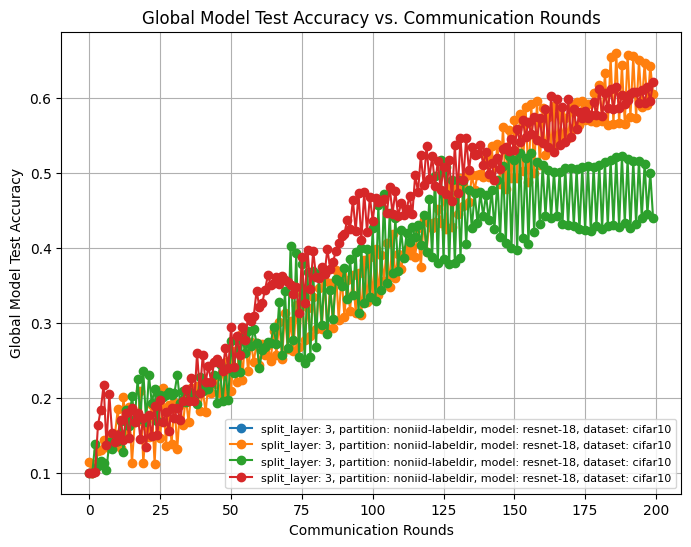

In [67]:
hyperparameter_filters = {
    "alg": "sflv1",
    "partition": "noniid-labeldir",
    "dataset": 'cifar10',
    'split_layer': "3",
    "comm_round": "200",
}

filtered_logs = filter_logs(log_data, hyperparameter_filters)
generate_graph(filtered_logs)

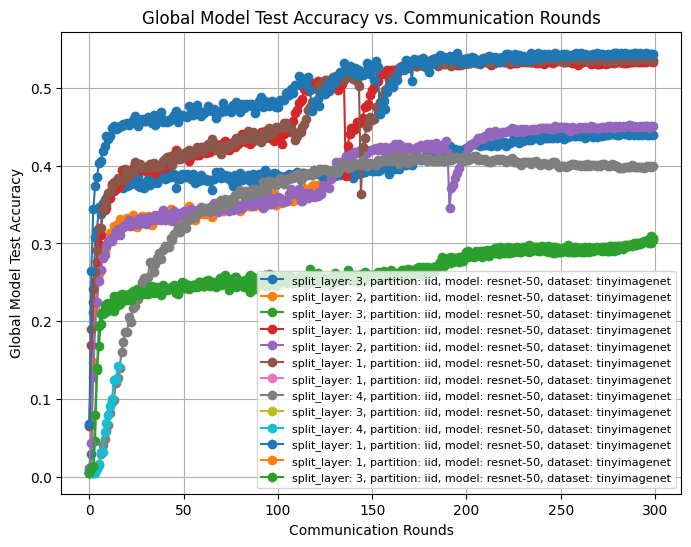

In [78]:
hyperparameter_filters = {
    "alg": "sflv2",
    "partition": "iid",
    "dataset": 'tinyimagenet',
    # 'split_layer': '2',
    'model': 'resnet-50',
}

filtered_logs = filter_logs(log_data, hyperparameter_filters)
generate_graph(filtered_logs)